# Yoonhyuck Woo, Rishika Thorat / Purdue University_Computer and Information Technology
# Final Project Title: Movie Recommendation System
# Professor: Jin Wei-Kocsis, Ph.D.

-reference: https://calvinfeng.gitbook.io/machine-learning-notebook/supervised-learning/recommender/neural_collaborative_filtering

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Concatenate, Dense
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import matplotlib
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import numpy as np

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Data

In [ ]:
movies = pd.read_csv('drive/MyDrive/ml-25m/movies.csv')
ratings = pd.read_csv('drive/MyDrive/ml-25m/ratings.csv')
tags = pd.read_csv('drive/MyDrive/ml-25m/tags.csv')

data = pd.merge(ratings, movies, on='movieId')

# New way of calling Dataset

In [ ]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Neural Collaborative Model

In [ ]:
def CF_model(input_data):
  data = input_data
  user_embed_dim = 32
  movie_embed_dim = 32

  # User and Movie Input Layers
  user_input = Input(shape=(1,), name='user_input')
  movie_input = Input(shape=(1,), name='movie_input')

  # User and Movie Embedding Layers
  user_embedding = Embedding(input_dim=data['userId'].max()+1, output_dim=user_embed_dim, input_length=1)(user_input)
  movie_embedding = Embedding(input_dim=data['movieId'].max()+1, output_dim=movie_embed_dim, input_length=1)(movie_input)

  # Flatten the Embedding Layers
  user_flat = Flatten()(user_embedding)
  movie_flat = Flatten()(movie_embedding)

  # Concatenate User and Movie Embeddings
  # concat = Concatenate()([user_flat, movie_flat])
  concat = Dot(axes=1)([user_flat, movie_flat])

  # Dense Layer
  dense1 = Dense(130, activation='relu')(concat)

  # Output Layer
  output = Dense(1)(dense1)

  # Model
  model = Model(inputs=[user_input, movie_input], outputs=output)
  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

  return model

# check Concatenate and Dot

In [ ]:
# data = input_data
user_embed_dim = 32
movie_embed_dim = 32

# User and Movie Input Layers
user_input = Input(shape=(1,), name='user_input')
movie_input = Input(shape=(1,), name='movie_input')

# User and Movie Embedding Layers
user_embedding = Embedding(input_dim=data['userId'].max()+1, output_dim=user_embed_dim, input_length=1)(user_input)
movie_embedding = Embedding(input_dim=data['movieId'].max()+1, output_dim=movie_embed_dim, input_length=1)(movie_input)

# Flatten the Embedding Layers
user_flat = Flatten()(user_embedding)
movie_flat = Flatten()(movie_embedding)

concat = Concatenate()([user_flat, movie_flat])
concat2 = Dot(axes=1)([user_flat, movie_flat])


print(user_flat.shape)
print(concat.shape)
print(concat2.shape)

(None, 32)
(None, 64)
(None, 1)


# Train

In [ ]:
model = CF_model(data)
checkpoint_path = "/content/drive/MyDrive/CF_training4/ckpt-{epoch:03d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
batch_size = 64
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0,
                                                 )


In [ ]:
model.save_weights(checkpoint_path.format(epoch=0))

In [ ]:
# Train the Collaborative Filtering Model
with tf.device('/device:GPU:0'):
  history = model.fit(
    [train_data['userId'].values.reshape(-1, 1), train_data['movieId'].values.reshape(-1, 1)],
    train_data['rating'].values,
    epochs=33,
    batch_size=batch_size,  # Add this line to specify batch size
    validation_split=0.1,
    callbacks=[cp_callback],
    verbose = 1
)

Epoch 1/33
281252/281252 [==============================] - 1110s 4ms/step - loss: 0.9922 - accuracy: 0.0310 - val_loss: 0.9543 - val_accuracy: 0.0311
Epoch 2/33
281252/281252 [==============================] - 1106s 4ms/step - loss: 0.9031 - accuracy: 0.0310 - val_loss: 0.9157 - val_accuracy: 0.0311
Epoch 3/33
281252/281252 [==============================] - 1095s 4ms/step - loss: 0.8521 - accuracy: 0.0310 - val_loss: 0.8936 - val_accuracy: 0.0311
Epoch 4/33
281252/281252 [==============================] - 1095s 4ms/step - loss: 0.8136 - accuracy: 0.0310 - val_loss: 0.8853 - val_accuracy: 0.0309
Epoch 5/33
281252/281252 [==============================] - 1128s 4ms/step - loss: 0.7813 - accuracy: 0.0310 - val_loss: 0.8705 - val_accuracy: 0.0311
Epoch 6/33
281252/281252 [==============================] - 1124s 4ms/step - loss: 0.7528 - accuracy: 0.0310 - val_loss: 0.8696 - val_accuracy: 0.0311
Epoch 7/33
281252/281252 [==============================] - 1103s 4ms/step - loss: 0.7270 - ac

In [ ]:
from sklearn.metrics import mean_absolute_error

y_hat = np.round(model.predict([test_data['userId'].values.reshape(-1, 1), test_data['movieId'].values.reshape(-1, 1)]
), decimals=2)
y_true = test_data['rating'].values
mean_absolute_error(y_true, y_hat)

156251/156251 [==============================] - 243s 2ms/step


0.8442555111022555

In [ ]:
print(y_hat)

[[3.48]
 [3.48]
 [3.48]
 ...
 [3.48]
 [3.48]
 [3.48]]


NameError: ignored

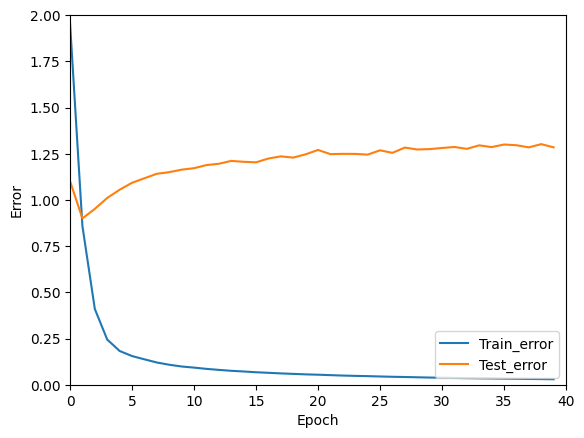

In [ ]:
# Visualize performance evaluation
plt.plot(history.history['loss'], label='Train_error')
plt.plot(history.history['val_loss'], label = 'Test_error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.xlim([0, len(history.history['loss'])])
plt.ylim([0, 2])
plt.legend(loc='lower right')

results = model.evaluate(x_test, y_test, verbose = 0, callbacks=[callback1])
print(results)
# print('Train Error:', round(results[0],7), '\t', 'Test Error:',  round(results[1], 7))

In [ ]:
os.listdir(checkpoint_dir)

latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

In [ ]:
# new_model = Model(inputs=[user_input, movie_input], outputs=output)

new_model = CF_model(data)

new_model.load_weights(latest)

In [ ]:
def generate_recommendations(user_id, model, top_n=10):
    CF_model = model
    user_movies = data[data['userId'] == user_id]['movieId'].unique()
    unrated_movies = movies[~movies['movieId'].isin(user_movies)]['movieId'].unique()

    predictions = new_model.predict([pd.Series([user_id] * len(unrated_movies)), unrated_movies])
    movie_ratings = pd.DataFrame({'movieId': unrated_movies, 'predicted_rating': predictions.flatten()})
    top_recommendations = movie_ratings.nlargest(top_n, 'predicted_rating')
    top_recommendations = pd.merge(top_recommendations, movies, on = 'movieId')

    # print(new_frame)
    return top_recommendations

In [ ]:
recommendations = generate_recommendations(133, new_model)
print("\nTop Movie Recommendations:")
print(recommendations[['title','genres', 'predicted_rating']].to_string(index=False))

1947/1947 [==============================] - 3s 1ms/step

Top Movie Recommendations:
                                              title                                      genres  predicted_rating
                                    Paperman (2012)                    Animation|Comedy|Romance          4.671002
                             Planet Earth II (2016)                                 Documentary          4.654060
                                Planet Earth (2006)                                 Documentary          4.647769
                                Forrest Gump (1994)                    Comedy|Drama|Romance|War          4.647602
Harry Potter and the Deathly Hallows: Part 2 (2011) Action|Adventure|Drama|Fantasy|Mystery|IMAX          4.603815
                   The Hounds of Baskerville (2012)                         Crime|Drama|Mystery          4.580274
                                      Dangal (2016)                                       Drama          4.575853
   